In [1]:









import os
from os import listdir
import cv2
import imutils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir("C:/Brain_multilabel_MRI_dataset");

In [2]:
os.getcwd()

'C:\\Brain_multilabel_MRI_dataset'

# Function for cropping MRI images

In [3]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

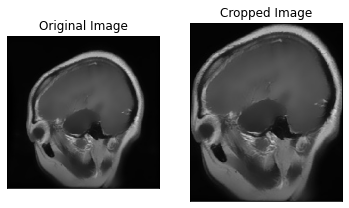

In [4]:
ex_img = cv2.imread('C:/Brain_Multilabel_MRI_dataset/Training/gt_denoised_images/image0.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [5]:
gt1 = plt.imread('C:/Brain_Multilabel_MRI_dataset/Training/gt_denoised_images/image1.jpg')
mt1 = plt.imread('C:/Brain_Multilabel_MRI_dataset/Training/mt_denoised_images/image1.jpg')
nt1 = plt.imread('C:/Brain_Multilabel_MRI_dataset/Training/nt_denoised_images/image1.jpg')
pt1 = plt.imread('C:/Brain_Multilabel_MRI_dataset/Training/pt_denoised_images/image1.jpg')

# Example of Glioma tumor

(-0.5, 223.5, 223.5, -0.5)

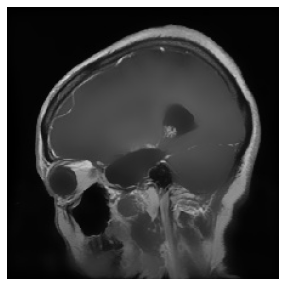

In [6]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(gt1)
plt.axis('off')

# Example of meningioma tumor

(-0.5, 223.5, 223.5, -0.5)

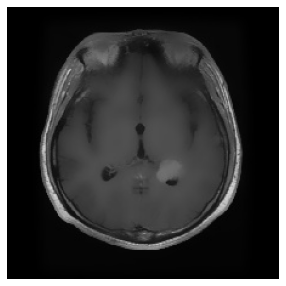

In [7]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(mt1)
plt.axis('off')

# Example of no tumor

(-0.5, 223.5, 223.5, -0.5)

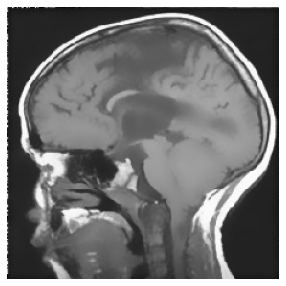

In [8]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(nt1)
plt.axis('off')

# Example of pituitary tumor

(-0.5, 223.5, 223.5, -0.5)

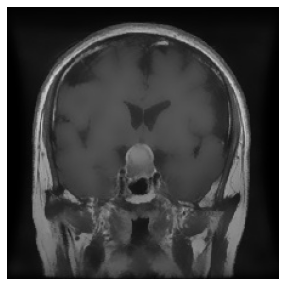

In [9]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(pt1)
plt.axis('off')

In [10]:
print(gt1.shape)

(224, 224, 3)


In [11]:
print(mt1.shape)

(224, 224, 3)


In [12]:
print(nt1.shape)

(224, 224, 3)


In [13]:
print(pt1.shape)

(224, 224, 3)


# Function for intensity normalization

In [14]:
def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

# Crop the input image & normalize it

In [15]:
datadir= "C:/Brain_Multilabel_MRI_dataset/Training"
CATEGORIES = ["gt_denoised_images","pt_denoised_images","mt_denoised_images","nt_denoised_images"]
x_train= []
train_label=[]
for i in CATEGORIES:
    train_path = os.path.join(datadir,i)
    tag = CATEGORIES.index(i)
    for img in os.listdir(train_path):
            image_arr = cv2.imread(os.path.join(train_path,img))
            image_array = crop_brain_contour(image_arr,plot=False)
            n_image_array=normalize(image_array)
            n_image_array= cv2.resize(n_image_array, (224,224))
            x_train.append(n_image_array)
            train_label.append(tag)

In [16]:
print(len(x_train))

2645


In [17]:
print(len(train_label))

2645


In [18]:
x_train=np.array(x_train)
train_label=np.array(train_label)

In [19]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(train_label)

Using TensorFlow backend.


In [20]:
from keras.applications.vgg16 import VGG16
VGG16_model=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in VGG16_model.layers:
    layer.trainable = False
VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Feature extraction using VGG16 for training data

In [21]:
train_feature_extractor=VGG16_model.predict(x_train)
train_features = train_feature_extractor.reshape(train_feature_extractor.shape[0], -1)

In [22]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators =50, random_state = 42)

# Random Forest on training dataset

In [23]:
# Train the model on training data
RF_model.fit(train_features, train_label)

RandomForestClassifier(n_estimators=50, random_state=42)

In [24]:
#Now predict using the trained RF model. 
prediction_RF_train= RF_model.predict(train_features)

In [25]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(train_label, prediction_RF_train))

Accuracy =  1.0


<AxesSubplot:>

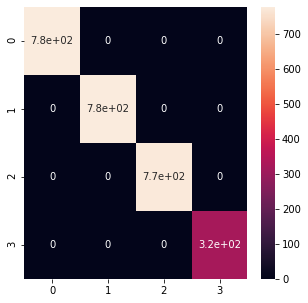

In [26]:
#Confusion Matrix - verify accuracy of each class
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(train_label, prediction_RF_train)
#print(cm)
sns.heatmap(cm, annot=True)

# Import testing data and apply pre-processing steps on it that were applied on training data

In [27]:
datadir= "C:/Brain_Multilabel_MRI_dataset/Testing"
CATEGORIES = ["denoised_gt_test","denoised_pt_test","denoised_mt_test","denoised_nt_test"]
x_test= []
test_label=[]
for i in CATEGORIES:
    test_path = os.path.join(datadir,i)
    tag = CATEGORIES.index(i)
    for img in os.listdir(test_path):
            test_image_arr= cv2.imread(os.path.join(test_path,img))
            test_image_array = crop_brain_contour(test_image_arr,plot=False)
            test_image_array=normalize(test_image_array)
            test_n_image_array= cv2.resize(test_image_array, (224,224))
            x_test.append(test_n_image_array)
            test_label.append(tag)

In [28]:
print(len(x_test))

261


In [29]:
print(len(test_label))

261


In [30]:
x_test=np.array(x_test)
test_label=np.array(test_label)

In [31]:
from keras.utils import to_categorical
y_test_one_hot = to_categorical(test_label)

# Feature extraction for test dataset

In [32]:
test_feature_extractor=VGG16_model.predict(x_test)
test_features = test_feature_extractor.reshape(test_feature_extractor.shape[0], -1)

In [33]:
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(test_features)

In [34]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_label, prediction_RF))

Accuracy =  0.9540229885057471


<AxesSubplot:>

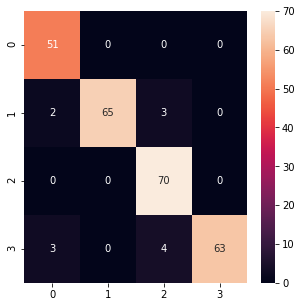

In [35]:
#Confusion Matrix - verify accuracy of each class
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

In [36]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(RF_model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
